In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import enlighten
from collections import defaultdict as ddict

#!source activate my-rdkit-env && python
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.rdmolops import SanitizeFlags

# from rdkit import Chem

from IPython.core.display import HTML

#ML requirements sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans


RDLogger.logger().setLevel(RDLogger.CRITICAL)

# RDLogger.logger().setLevel(RDLogger.WARNING)

not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']
#molecule descriptor calculator
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  13


2022-06-29 09:51:35.734252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 09:51:35.765304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 09:51:35.768979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 09:51:35.769090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Defining functions to use

In [4]:
#write some stuff
def stats(A,B):
    assert len(A) == len(B)
    R2 = np.round(r2_score(A, B))
    MAE = np.round(mean_absolute_error(A,B))
    return R2, MAE

def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))

def remove_aromatisation(mol):
    # for atom in mol.GetAromaticAtoms():
    #     #bugfixing
    #     # print(atom.getIsAromatic())
    #     # print(atom.getSymbol())
    #     atom.SetIsAromatic(False)

    for atom in mol.GetAtoms():
        if (not atom.IsInRing()) and atom.GetIsAromatic():
            atom.SetIsAromatic(False)
    for bond in mol.GetBonds():
        if (not bond.IsInRing()) and bond.GetIsAromatic():
            bond.SetIsAromatic(False)

def get_frag_env(mol, atom_x, radius):
    bond_x = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_x)
    if len(bond_x) == 0:
        return None
    atom_x_set = set()
    for b_x in bond_x:
        b = mol.GetBondWithIdx(b_x)
        atom_x_set.add(b.GetBeginAtomIdx())
        atom_x_set.add(b.GetEndAtomIdx())
    return Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol, atom_x_set, bond_x), sanitize=False)

def get_frag(mol, atom_x, radius):
    frag = None
    r = radius

    while frag is None and r > 0:
        frag = get_frag_env(mol, atom_x, r)
        r -= 1
    if frag is None:
        raise ValueError("No fragment extracted")

    # error/issue catching#or
    r = radius + 1
    #sanitised to calculated descriptors
    not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)
    count = 0
    tot_atoms = frag.GetNumAtoms()
    while not_sanitised:
        if count > tot_atoms:
            raise ValueError("Unable to sanitise molecules")
        # probs = Chem.DetectChemistryProblems(frag)
        # for p in probs:
        #     print("Issue is: " + p.GetType())
        if not_sanitised == SanitizeFlags.SANITIZE_KEKULIZE:
            # if count == 5:
            #     raise ValueError("Unable to sanitise molecules")
            remove_aromatisation(frag)
        elif not_sanitised == SanitizeFlags.SANITIZE_PROPERTIES:
            frag = get_frag_env(mol, atom_x, r)
            r += 1
        not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)
        count += 1
    # print(Chem.MolToSmiles(frag))
    return frag

# def fix_nitrogen(mol):
#     mol.UpdatePropertyCache(strict=False)
#     ps = Chem.DetectChemistryProblems(mol)
#     if ps:
#         for p in ps:
#             if p.GetType() == 'AtomValenceException':
#                 at = mol.GetAtomWithIdx(p.GetAtomIdx())
#             if at.GetAtomicNum()==7 and at.GetFormalCharge()==0 and at.GetExplicitValence()==4:
#                 at.SetFormalCharge(1)
#     if not ps:
#         print("Chemically fine")
    # return mol


In [5]:
#assay identification number
#AID as written in PubChem database

#hERG ion channel modulator assay
assay = 1511

In [6]:
#backup excel method
excelfile = "AID_1511_datatable_all.csv"

In [7]:
#compile Assay molecules into SDF
from pubapi import get_data_AID_csv as assayinfo

#get assay info

try:
    assay_info = assayinfo.get_data_AID_csv(assay)

except:
    print("Error in download")
#backup method

# with open(excelfile, 'r') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     assay_info = []
#     headers = ['PUBCHEM_ASSAY_ID']
#     for id, row in enumerate(reader):
#         if id == 0:
#             headers.append(row[1:4])
#             assay_info.append(headers)
#         try: 
#             int(row[0]) == 1
#         except ValueError:
#             #line is descriptive
#             continue
#         if row[2] == '':
#             #CID is missing/not present
#             row[2] = 0
#             #continue

#         line = [assay, int(row[1]), int(row[2]), row[3]]
#         assay_info.append(line)



Number of substances tested in assay AID 1511 are: 305679
Assay size is over 10,000
This exceeds the max number of lines that can be requested at once.
Requesting info of assay 1511


Done.
Assay 1511 has been successfully downloaded.


In [8]:
all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])

# all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])
#get list of CIDs from the assay
print(all_df.head(10))

CIDs = all_df['PUBCHEM_CID'].to_list()

# from pubapi import get_SDF_CIDs as SDFs

# SDFs.compile_SDFs(CIDs)


   PUBCHEM_ASSAY_ID  PUBCHEM_SID  PUBCHEM_CID PUBCHEM_ACTIVITY_OUTCOME
0              1511     56314828         1988                 Inactive
1              1511     56321651       425322                 Inactive
2              1511     56322145     24981957                 Inactive
3              1511     51090143      7384392                 Inactive
4              1511     51090795      7423030                 Inactive
5              1511     51090141      7526417                 Inactive
6              1511     51090145     16268999                 Inactive
7              1511     51090492     18573514                 Inactive
8              1511     51090139     18577942                 Inactive
9              1511     51089977     18582778                 Inactive


In [9]:
all_df["PUBCHEM_CANONICAL_SMILES"] = np.nan

In [10]:
#add the SMILES from the SQL database to each of the CIDs in the 

#do it with internal mariadb
#uncomment
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

from search_laurus import query_db

query = f'SELECT * FROM aggregator.pubchem_compound WHERE ' 

pbar = enlighten.Counter(total=(len(CIDs)), desc='Querying Laurus...', unit='ticks')
for i in CIDs:
    
    #Search for CIDs
    CID_search = query + f'pubchem_id = {i};' 
    info = query_db(CID_search)

    #parse
    for j in info:
        # pubchem = j[0]
        # compound = j[1]
        smiles = j[5]
        all_df.loc[all_df["PUBCHEM_CID"] == i, 'PUBCHEM_CANONICAL_SMILES'] = smiles

    pbar.update()



CC(=O)OC1=CC=CC=C1C(=O)O


In [11]:
#now convert the SMILES strings to MOL objects
PandasTools.AddMoleculeColumnToFrame(all_df, 'PUBCHEM_CANONICAL_SMILES', 'MOL', includeFingerprints=True)


In [12]:
training_data = all_df.copy()

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,

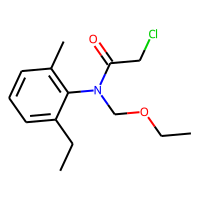
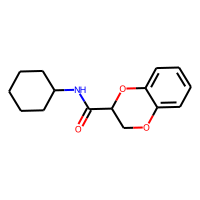
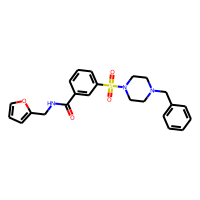
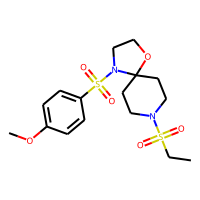

In [13]:
show(training_data.head(4))

In [14]:
#write molecules to SDF
PandasTools.WriteSDF(all_df, f'{assay}_compounds.sdf', molColName='MOL', properties=all_df.columns)

In [37]:
#TODO
#get fingerprints and split into fragments.
min_radius = 3
max_radius = 5

radii = list(range(min_radius, max_radius))

In [16]:
# test_df = training_data[129607:129610]

In [17]:
# show(test_df.head(4))

In [18]:
# frags = ddict(list)

# #check to see how long this may actually take
# frag_prog = enlighten.Counter(total=(len(test_df)), desc='Creating Fragments...', unit='ticks')

# # show(test_df.drop(129607, axis=0))

# for index, row in test_df.iterrows():
#     atom_x = 0
#     mol = row.MOL
#     check_frags = []
#     for i in radii:
#         try:
#             # frags[i].append(get_frag(mol, atom_x, i))
#             frag = get_frag(mol, atom_x, i)
#             check_frags.append((i, frag))
#         except:
#             print(index)
#             # test_df.drop(index, axis=0, inplace=True)

#     if len(check_frags) != len(radii):
#         test_df.drop(index, axis=0, inplace=True)
#     else:
#         for i in check_frags:
#             frags[i[0]].append(i[1])
#     frag_prog.update()

# for i in radii:
#     test_df[f'FRAG_R{i}'] = frags[i]

# show(test_df.head(4))


In [19]:
frags = ddict(list)

#check to see how long this may actually take
frag_prog = enlighten.Counter(total=(len(training_data)), desc='Creating Fragments...', unit='ticks')

for index, row in training_data.iterrows():
    atom_x = 0
    mol = row.MOL
    check_frags = []
    for i in radii:
        try:
            # frags[i].append(get_frag(mol, atom_x, i))
            frag = get_frag(mol, atom_x, i)
            check_frags.append((i, frag))
        except:
            print(f'Removing line: {index}')
    if len(check_frags) != len(radii):
        training_data.drop(index, axis=0, inplace=True)
    else:
        for i in check_frags:
            frags[i[0]].append(i[1])
            
    frag_prog.update()


for i in radii:
    training_data[f'FRAG_R{i}'] = frags[i]

# show(training_data.head(4))




Removing line: 77430
Removing line: 81689
Removing line: 83743
Removing line: 84663
Removing line: 106970
Removing line: 111820
Removing line: 125560
Removing line: 129607
Removing line: 132093
Removing line: 132093
Removing line: 135417
Removing line: 135417
Removing line: 139592
Removing line: 153332
Removing line: 173613
Removing line: 174838
Removing line: 181072
Removing line: 181558
Removing line: 193700
Removing line: 193700
Removing line: 215789
Removing line: 229814
Removing line: 231445
Removing line: 241868
Removing line: 290377
Removing line: 291099
Removing line: 302647
Removing line: 302647


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL,FRAG_R3,FRAG_R4
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,,

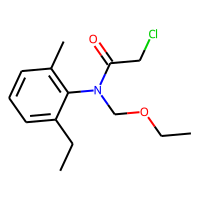
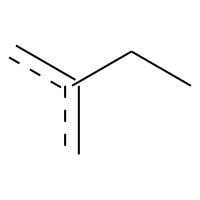
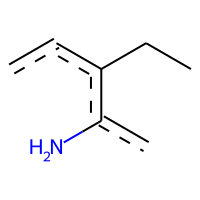
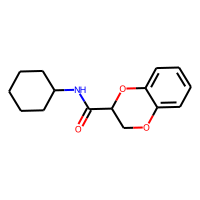
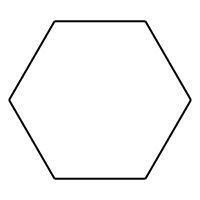
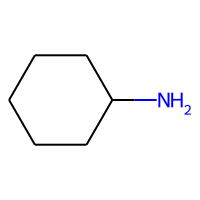
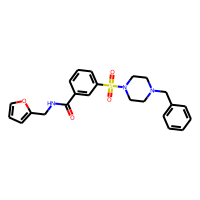
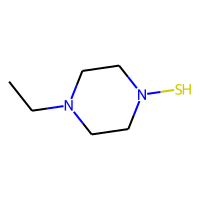
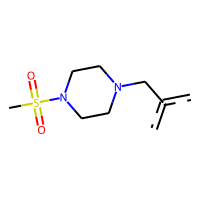
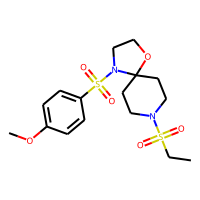
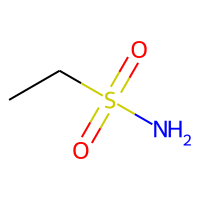
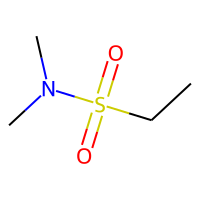

In [20]:
show(training_data.head(4))

In [71]:
# keys = radii + [max_radius]
# descs_check = ddict(list)

# limit = 2

# for index, row in training_data.iterrows():
#     if index > limit:
#         break
#     for i in keys:
#         mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']
#         descs_check[i].append(desc_calc.CalcDescriptors(mol))

# print(len(descs_check[4]))

3


In [73]:
#Calculate descriptors for fragments

keys = radii + [max_radius]

#this guy used a dictionary like a list...
descr = ddict(list)

descriptor_pb = enlighten.Counter(total=(len(training_data)), desc='Calculating descriptors...', unit='ticks')

# limit = 2

for index, row in training_data.iterrows():
    nan_flag = False

    #list indexing > dictionaries
    descriptors_check = []
    # if index > limit:
    #     break
    for i in keys:
        # print(i)
        mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']   
        descriptor = desc_calc.CalcDescriptors(mol)
        for j in descriptor:
            if np.isnan(j):
                nan_flag = True
                break 
        if nan_flag:
            print(index)
            break
        descriptors_check.append(descriptor)
        # descr[i].append(descriptor)
        #issue is it may append before molecules are checked
        
        
    if nan_flag:
        print(f'Line {index} contains NaN values, removing...')
        training_data.drop(index, inplace=True)
    else:
        for ID, k in enumerate(keys):
            descr[k].append(descriptors_check[ID])

    #testing the length of the frag dict
    descriptor_pb.update()

In [44]:
#create fingerprints for all molecules/fragments

morgan0 = ddict(list)
morgan1 = ddict(list)
morgan2 = ddict(list)
morgan3 = ddict(list)
topol = ddict(list)
atpair = ddict(list)

fingerprint_pb = enlighten.Counter(total=(len(training_data)), desc='Calculating fingerprints...', unit='ticks')

for index, row in training_data.iterrows():
    for i in keys:
        mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']
        morgan0[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=0))
        morgan1[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=1))
        morgan2[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=2))
        morgan3[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3))
        topol[i].append(Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
        atpair[i].append(Chem.GetHashedAtomPairFingerprintAsBitVect(mol))
    fingerprint_pb.update()


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL,FRAG_R3,FRAG_R4
0,1511,56314828,1988,0,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,,
1,1511,56321651,425322,0,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,,
2,1511,56322145,24981957,0,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,,
3,1511,51090143,7384392,0,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,,

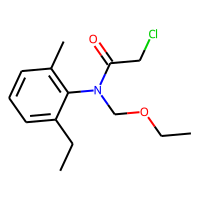
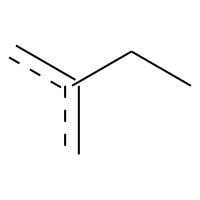
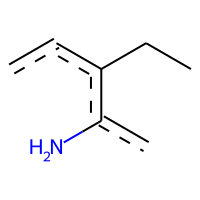
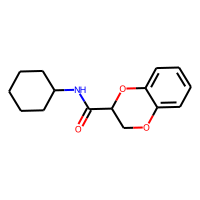
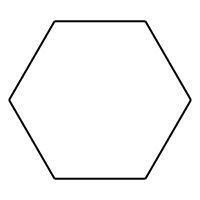
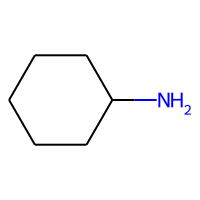
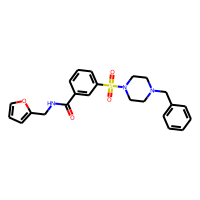
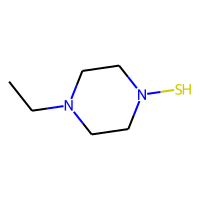
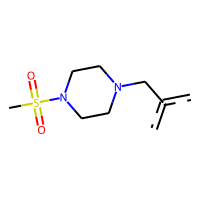
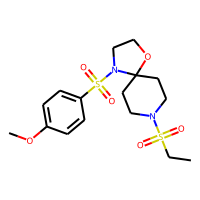
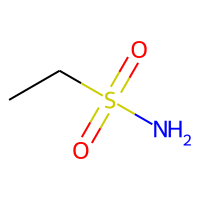
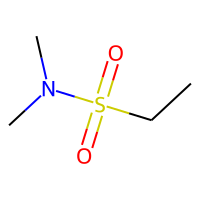

In [45]:
#replace activity with 1 if active and 0 if inactive
training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace("Inactive", 0, inplace=True)
training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace("Active", 1, inplace=True)

show(training_data.head(4))

In [25]:
# dataset = all_df.copy()
# y_dataset_test = dataset["PUBCHEM_ACTIVITY_OUTCOME"]
# encode = LabelEncoder()
# encode.fit(y_dataset_test)
# encoded_y = encode.transform(y_dataset_test)

# # print(encoded_y)

In [46]:
training_data.nunique()

PUBCHEM_ASSAY_ID                 1
PUBCHEM_SID                 305427
PUBCHEM_CID                 305360
PUBCHEM_ACTIVITY_OUTCOME         2
PUBCHEM_CANONICAL_SMILES    303867
MOL                         305427
FRAG_R3                     305427
FRAG_R4                     305427
dtype: int64

In [47]:
seed = 20

# folds = 5
# jobs = 12

y_data = training_data["PUBCHEM_ACTIVITY_OUTCOME"]
x_data = dict(Descriptors=descr, Morgan0=morgan0, Morgan1=morgan1, Morgan2=morgan2, 
                  Morgan3=morgan3, Topological=topol, AtomPair=atpair)

# kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
# spl = list(kf.split(descr[max_radius], y_data))

In [48]:
trees = 1000

In [ ]:
#maybe skip this step

#cross validation of the possible descriptors

# all_scores = {}
# for dsetname, dset in x_data.items():
#     # print(dset)
#     print(f'Random Forest - {dsetname}:')
#     scores = {}
#     for i in dset:
#         # print(i)
#         # print(dset[i])
#         est = RandomForestClassifier(n_estimators=trees, random_state=seed, n_jobs=jobs)
#         score = cross_val_score(est, dset[i], y_data, cv=spl, error_score='raise')
#         print(score)
#         scores[i] = dict(r2=np.mean(score), r2_std=np.std(score))
#         print(f'\tRadius {i if i != max_radius else "M"} - R²: '
#               f'{np.round(scores[i]["r2"], 3)} ± {np.round(scores[i]["r2_std"], 3)}')
#     all_scores[dsetname] = scores

In [ ]:
#create train/test split
jobs = 12
radius = 4
test_partition = 0.2
#TODO: NaNs NEED TO BE REMOVED, FIND A METHOD TO DO THIS
print(len(descr[radius]))
print(len(y_data))

assert len(descr[radius]) == len(y_data)

# x_train, x_test, y_train, y_test = train_test_split(descr[radius], y_data, test_size=test_partition, random_state=seed)


In [ ]:
#setup train/test set
x_train, x_test, y_train, y_test = train_test_split(descr[radius], y_data, test_size=test_partition, random_state=seed)

In [44]:
#remove NaN
err_x_test = []
err_x_train = []

for n, i in enumerate(x_train):
    # print(i)
    # break
    for j in i:
        if np.isnan(j):
            # err_x_train.append(n)
            print(j)
            print(n)
# for n, i in enumerate(x_test):
#     if np.isnan(i):
#         err_x_test.append(n)

# err_x_test = sorted(err_x_test, reverse=True)
# err_x_train = sorted(err_x_test, reverse=True)

# print(len(err_x_test))
# print(len(err_x_train))

# for i in err_x_test:
#     del x_test[i]
# for i in err_x_train:
#     del x_train[i]

# y_train.drop(y_train.index[err_x_train], inplace=True)
# y_test.drop(y_test.index[err_x_test], inplace=True)

nan
6852
nan
6852
nan
6852
nan
6852
nan
6852
nan
6852
nan
6852
nan
6852
nan
11487
nan
11487
nan
11487
nan
11487
nan
11487
nan
11487
nan
11487
nan
11487
nan
46451
nan
46451
nan
46451
nan
46451
nan
46451
nan
46451
nan
46451
nan
46451
nan
60012
nan
60012
nan
60012
nan
60012
nan
60012
nan
60012
nan
60012
nan
60012
nan
66514
nan
66514
nan
66514
nan
66514
nan
66514
nan
66514
nan
66514
nan
66514
nan
70352
nan
70352
nan
70352
nan
70352
nan
70352
nan
70352
nan
70352
nan
70352
nan
76591
nan
76591
nan
76591
nan
76591
nan
76591
nan
76591
nan
76591
nan
76591
nan
87398
nan
87398
nan
87398
nan
87398
nan
87398
nan
87398
nan
87398
nan
87398


KeyboardInterrupt: 

In [38]:
print(len(x_train))

244516


In [35]:
err =np.argwhere(np.isnan(x_train))
print(err)

[[  6852     13]
 [  6852     14]
 [  6852     15]
 [  6852     16]
 [  6852     17]
 [  6852     18]
 [  6852     19]
 [  6852     20]
 [ 11487     13]
 [ 11487     14]
 [ 11487     15]
 [ 11487     16]
 [ 11487     17]
 [ 11487     18]
 [ 11487     19]
 [ 11487     20]
 [ 46451     13]
 [ 46451     14]
 [ 46451     15]
 [ 46451     16]
 [ 46451     17]
 [ 46451     18]
 [ 46451     19]
 [ 46451     20]
 [ 60012     13]
 [ 60012     14]
 [ 60012     15]
 [ 60012     16]
 [ 60012     17]
 [ 60012     18]
 [ 60012     19]
 [ 60012     20]
 [ 66514     13]
 [ 66514     14]
 [ 66514     15]
 [ 66514     16]
 [ 66514     17]
 [ 66514     18]
 [ 66514     19]
 [ 66514     20]
 [ 70352     13]
 [ 70352     14]
 [ 70352     15]
 [ 70352     16]
 [ 70352     17]
 [ 70352     18]
 [ 70352     19]
 [ 70352     20]
 [ 76591     13]
 [ 76591     14]
 [ 76591     15]
 [ 76591     16]
 [ 76591     17]
 [ 76591     18]
 [ 76591     19]
 [ 76591     20]
 [ 87398     13]
 [ 87398     14]
 [ 87398     1

In [28]:
#Fire away
rf = RandomForestClassifier(n_estimators=trees, random_state=seed, n_jobs=jobs)
rf.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').